In [1]:
# !pip install transformers datasets

In [2]:
# !pip install spacy

In [3]:
# !pip install nltk

In [4]:
# !pip install contractions

In [5]:
# !pip install --upgrade pip

In [6]:
# !pip install gensim

In [19]:
# !pip install fasttext

In [51]:
# !pip3 install torch torchvision

In [57]:
# !pip3 install transformers

In [62]:
import pandas as pd
import spacy
import numpy as np
import torch
import os
import fasttext
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

### Dataset

In [63]:
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors

train_data, validation_data = load_dataset("roneneldan/TinyStories", split = ['train', 'validation'])

In [64]:
train_data['text'][115]

"Once there was a little girl called Lucy who wanted to sell something very special. She carefully wrapped up her knee in a box and took it outside.\n\nOnce she got to the market place, Lucy could see the many different people gathered together and she felt shy. She began to shout, â€œIâ€™m selling my knee!â€\n\nOne of the people at the market was an old woman who had seen many things in her life. She approached Lucy and said, â€œDo you want some help selling your knee?â€\n\nLucy nodded and smiled. The old woman was very compassionate and kind and she soon found a buyer who was willing to pay a good amount of money for Lucy's knee. Lucy could not believe her luck!\n\nThe old woman then said, â€œYou should always be brave and use your compassion when trying to sell something. You never know who might be in the market place and be willing to buy it.â€\n\nLucy smiled and said, â€œThank you so much for your advice and for helping me to sell my knee.â€\n\nThe old woman smiled back at her an

### Data cleaning

In [65]:
for i in train_data:
    print(i['text'])
    break

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.


In [66]:
def lowerc(x):
    return {"text": x["text"].lower()}

train_data = train_data.map(lowerc)
validation_data = validation_data.map(lowerc)

In [67]:
import re
def punc(data):
    return {'text' : re.sub(r"[^A-Za-z\s:]", "", data['text'])}

train_data = train_data.map(punc)
validation_data = validation_data.map(punc)

In [68]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download("punkt_tab")

def nltk_tokenize(example):
    return {"tokens": word_tokenize(example["text"])}

tok_train_data = train_data.map(nltk_tokenize)
tok_val_data = validation_data.map(nltk_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/animeshsingh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [75]:
tok_train_data

Dataset({
    features: ['text', 'tokens'],
    num_rows: 2119719
})

In [69]:
tok_val_data['tokens'][115][:5]

['once', 'upon', 'a', 'time', 'there']

In [70]:
# import contractions
# def cont(data):
#     return {'text' : contractions.fix(data['text'])}

# train_data = train_data.map(cont)
# validation_data = validation_data.map(cont)

### Fasttext Word level tok.

In [71]:
import fasttext

# fst_model = fasttext.train_unsupervised('tok_train_txt.txt', model = 'skipgram', dim = 300, thread = 4)

In [10]:
with open('tok_train_txt.txt', 'w', encoding = 'utf-8') as f:
    for tokens in tok_train_data['tokens']:
        if not tokens:
            continue
        if isinstance(tokens, list):
            tokens = ['<sos>'] + tokens + ['<eos>'] # Manually added <eos> and <sos>
            f.write(' '.join(map(str, tokens)) + '\n')
        else:
            f.write(str(tokens).strip() + '\n')

In [11]:
# fst_model.save_model("fst_fntnd.bin")
fst_model = fasttext.load_model("/Users/animeshsingh/Desktop/Models/fst_fntnd.bin")

In [77]:
fst_dim = fst_model.get_dimension()
fst_dim

300

In [3]:
def create_embedding_matrix(tokenizer_vocab, fst_model, embedding_dim):
    vocab_size = len(tokenizer_vocab)
    embeddings = torch.zeros(vocab_size, embedding_dim)
    
    found = 0
    for token, idx in tokenizer_vocab.items():
        try:
            embeddings[idx] = torch.FloatTensor(fst_model.wv[token])
            found += 1
        except KeyError:
            embeddings[idx] = torch.randn(embedding_dim) * 0.1 #for new oov vectors
    
    print(f"Found {found}/{vocab_size} tokens in FastText model")
    return embeddings

In [13]:
vector = fst_model.get_sentence_vector('i will get full marks')
print(vector.shape) 

(300,)


In [14]:
# with open("/Users/animeshsingh/Desktop/Models/tok_train_txt.txt", "r", encoding = "utf-8") as f:
#     lines = [line.strip().split() for line in f.readlines() if line.strip()]

lines = []
with open("/Users/animeshsingh/Desktop/tok_train_txt_small.txt", "r", encoding = "utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            lines.append(line.split())

dim = (300,)

In [2]:
#Very slow, Didn't use!

# sequences = []
# for words in lines:
#     vectors = [fst_model.get_word_vector(i) for i in words]
#     seq_tensor = torch.tensor(vectors, dtype = torch.float32)
#     sequences.append(seq_tensor)

In [17]:
sequences = []
# dim = fst_model.get_dimension()
# for seq in lines:
#     T = len(seq)
#     if T == 0:
#         continue
#     buf = np.empty((T, dim), dtype = np.float32)
#     for i, w in enumerate(seq):
#         buf[i, :] = fst_model.get_word_vector(w)
#     sequences.append(torch.from_numpy(buf))

def load_lines(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                yield line.split()
                
for tokens in load_lines("/Users/animeshsingh/Desktop/tok_train_txt_small.txt"):
    vectors = [fst_model.get_word_vector(i) for i in tokens]
    seq_tensor = torch.tensor(vectors, dtype = torch.float32)
    sequences.append(seq_tensor)

#### Padding (with 0s and not appending "pad" to the vocab)

In [31]:
from torch.nn.utils.rnn import pad_sequence
padded = []
def paddy(x):
    padded = pad_sequence(
        [torch.tensor(seq) for seq in x],
        batch_first = True, padding_value=0
    )
    return padded
print(padded)

[]


In [58]:
padded_train = paddy(sequences)

/var/folders/0w/13hqjsqx09vggh9kcnbrp62w0000gn/T/ipykernel_17485/3448172882.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(seq) for seq in x],


#### FastText Embedding using Gensim (Did not use in the final model)

In [ ]:
from gensim.models.fasttext import load_facebook_model

model = load_facebook_model(r"D:\cc.en.300.bin")

print(model.wv["apple"][:10])      # first 10 dimensions
print(model.vector_size)           # 300

In [24]:
def add_embeddings(data):
    vectors = [model.wv.get_vector(tok).astype(np.float32)
               if tok in model.wv.key_to_index
               else np.zeros(model.vector_size, dtype = np.float32)
               for tok in data["tokens"]]
    data["embeddings"] = vectors
    return data

emb_train_data = tok_val_data.map(add_embeddings)
print(np.array(emb_train_data[0]["embeddings"]).shape)

Map:   0%|          | 0/21990 [00:00<?, ? examples/s]

(64, 300)


### Pos Encoding

In [11]:
import torch, math

def pos_enc(seq_len = 250, dim = 300):
    pos = torch.arange(seq_len).unsqueeze(1).float()
    denom = torch.pow(10000, (-torch.arange(0, dim, 2).float() / dim))
    posenc = torch.zeros(seq_len, dim)
    posenc[:, 0::2] = torch.sin(pos / denom)
    posenc[:, 1::2] = torch.cos(pos / denom)
    return posenc

In [12]:
posenc = pos_enc()

In [14]:
posenc.shape

torch.Size([250, 300])

### Final Embedding 

In [49]:
def final_emb(x):
    tokens = x.split()
    seq_len = len(tokens)
    embeddings = [fst_model.get_word_vector(t) for t in tokens]
    embeddings = np.stack(embeddings)
    return posenc[:seq_len, :] + embeddings

In [50]:
emb = final_emb('i am going on a trip this winter')
emb

/var/folders/0w/13hqjsqx09vggh9kcnbrp62w0000gn/T/ipykernel_8787/3478609880.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return posenc[:seq_len, :] + embeddings


tensor([[-0.1332,  1.0258, -0.0253,  ...,  1.0522, -0.0031,  0.8893],
        [ 0.7767,  0.5119,  1.0907,  ..., -0.5351, -0.8957, -0.1369],
        [ 1.0022, -0.3728,  1.0061,  ..., -0.1493, -0.0532, -0.9673],
        ...,
        [-1.0829,  0.4869, -0.9610,  ...,  1.0307, -0.5332,  0.3246],
        [-0.6165,  1.1678,  0.1792,  ...,  0.2780, -0.3805, -0.8971],
        [ 0.9023,  0.6785,  1.1042,  ..., -0.9052,  0.6768, -0.5415]])

### LayerNorm

In [4]:
def layernorm(x, dim = 300):
    gamma = torch.ones(d_model)
    beta = torch.zeros(d_model)
    mean = torch.mean(x)
    std = torch.std(x)
    lnorm = (gamma * (x - mean) / (std + 0.00001)) + beta
    return lnorm

### Decoder and Transformer

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
# from gensim.models import FastText
import fasttext
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
device = 'cpu'

### NLTK WordPiece tokenizer

In [6]:
class NLTKTokenizer:
    def __init__(self, texts, max_vocab_size=50000):
        """Word-level tokenizer using NLTK"""
        self.pad_token = '<pad>'
        self.sos_token = '<sos>'
        self.eos_token = '<eos>'
        self.unk_token = '<unk>'
        
        # Build vocab
        word_counts = Counter()
        for text in tqdm(texts, desc="Building vocab"):
            tokens = word_tokenize(text.lower())
            word_counts.update(tokens)
        
        self.token2idx = {
            self.pad_token: 0,
            self.sos_token: 1,
            self.eos_token: 2,
            self.unk_token: 3
        }
        
        for word, _ in word_counts.most_common(max_vocab_size - 4):
            self.token2idx[word] = len(self.token2idx)
        
        self.idx2token = {v: k for k, v in self.token2idx.items()}
        self.vocab_size = len(self.token2idx)
    
    def encode(self, text):
        tokens = word_tokenize(text.lower())
        return [self.token2idx.get(t, self.token2idx[self.unk_token]) for t in tokens]
    
    def decode(self, ids):
        return ' '.join([self.idx2token.get(i, self.unk_token) for i in ids])
    
    def get_vocab(self):
        return self.token2idx
    
    def __len__(self):
        return self.vocab_size

### Dataset loader with tokenization

In [7]:
class TinyStoriesDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_len=64):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data = []
        
        for item in tqdm(hf_dataset, desc = "Processing dataset"):
            text = item['text']
            ids = tokenizer.encode(text)
            ids = [tokenizer.token2idx[tokenizer.sos_token]] + ids + [tokenizer.token2idx[tokenizer.eos_token]]
            
            if len(ids) <= max_len:
                self.data.append(ids)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ids = self.data[idx]
        padded = ids + [self.tokenizer.token2idx[self.tokenizer.pad_token]] * (self.max_len - len(ids))
        return torch.LongTensor(padded[:self.max_len])

### Transformer components

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [9]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### MHA with KV-Caching

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None, cache=None):
        B, T, C = x.shape
        
        Q = self.W_q(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        
        # KV caching
        if cache is not None:
            if cache['k'] is not None:
                K = torch.cat([cache['k'], K], dim=2)
                V = torch.cat([cache['v'], V], dim=2)
            cache['k'] = K
            cache['v'] = V
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attn = F.softmax(scores, dim=-1)
        attn_weights = attn.clone()
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.W_o(out)
        
        return out, attn_weights

In [11]:
class FFN(nn.Module):
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.fc2(self.dropout(F.gelu(self.fc1(x))))

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = FFN(d_model, d_ff, dropout)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask = None, cache = None):
        attn_out, attn_weights = self.attn(self.norm1(x), mask, cache)
        x = x + self.dropout(attn_out)
        ff_out = self.ff(self.norm2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights

### Transformer with Beam Search Decoding

In [13]:
class decod(nn.Module):
    def __init__(self, vocab_size, d_model=300, n_layers=3, n_heads=6, 
                 d_ff=None, max_len=64, dropout=0.1, pretrained_embeddings=None):
        super().__init__()
        
        self.d_model = d_model
        self.max_len = max_len
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        self.norm = LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def create_causal_mask(self, seq_len, device):
        mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
        return mask.view(1, 1, seq_len, seq_len)
    
    def forward(self, x, cache=None):
        B, T = x.shape
        device = x.device
        
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        mask = self.create_causal_mask(T, device)
        
        attn_weights_list = []
        for i, layer in enumerate(self.layers):
            layer_cache = cache[i] if cache else None
            x, attn_weights = layer(x, mask, layer_cache)
            attn_weights_list.append(attn_weights)
        
        x = self.norm(x)
        logits = self.fc_out(x)
        
        return logits, attn_weights_list
    
    def generate(self, prompt_ids, tokenizer, max_len = 100, temperature = 1.0, 
                 top_k = 50, use_kv_cache = True):
        # Stochastic sampling generation
        self.eval()
        device = next(self.parameters()).device
        
        generated = prompt_ids.copy()
        x = torch.LongTensor([generated]).to(device)
        
        cache = None
        if use_kv_cache:
            cache = [{'k': None, 'v': None} for _ in self.layers]
        
        with torch.no_grad():
            for _ in range(max_len):
                if use_kv_cache and cache[0]['k'] is not None:
                    logits, _ = self.forward(x[:, -1:], cache)
                else:
                    logits, _ = self.forward(x, cache)
                
                logits = logits[:, -1, :] / temperature
                
                if top_k > 0:
                    top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                    probs = F.softmax(top_k_logits, dim = -1)
                    next_token_idx = torch.multinomial(probs, 1)
                    next_token = top_k_indices.gather(-1, next_token_idx)
                else:
                    probs = F.softmax(logits, dim = -1)
                    next_token = torch.multinomial(probs, 1)
                
                generated.append(next_token.item())
                
                if next_token.item() == tokenizer.token2idx[tokenizer.eos_token]:
                    break
                
                x = torch.cat([x, next_token], dim = 1)
        
        return generated
    
    def beam_search(self, prompt_ids, tokenizer, max_len=50, beam_width=5):
        """Beam search decoding"""
        self.eval()
        device = next(self.parameters()).device
        
        beams = [(prompt_ids, 0.0)]
        
        with torch.no_grad():
            for _ in range(max_len):
                candidates = []
                
                for seq, score in beams:
                    if seq[-1] == tokenizer.token2idx[tokenizer.eos_token]:
                        candidates.append((seq, score))
                        continue
                    
                    x = torch.LongTensor([seq]).to(device)
                    logits, _ = self.forward(x)
                    log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
                    
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                    
                    for log_prob, idx in zip(top_log_probs[0], top_indices[0]):
                        new_seq = seq + [idx.item()]
                        new_score = score + log_prob.item()
                        candidates.append((new_seq, new_score))
                
                beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
                
                if all(seq[-1] == tokenizer.token2idx[tokenizer.eos_token] for seq, _ in beams):
                    break
        
        return beams[0][0]

### training function with Grad. Accumulation

In [14]:
def train_epoch(model, dataloader, optimizer, device, grad_accum_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
        batch = batch.to(device)
        x = batch[:, :-1]
        y = batch[:, 1:]
        
        logits, _ = model(x)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            y.reshape(-1),
            ignore_index=0
        )
        
        (loss / grad_accum_steps).backward()
        
        if (batch_idx + 1) % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            
            logits, _ = model(x)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                y.reshape(-1),
                ignore_index=0
            )
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

### Eval Metrics

In [15]:
def compute_perplexity_bleu(model, tokenizer, val_dataset, device, n_samples=50):
    """Compute average perplexity and BLEU score"""
    bleu_metric = load("bleu")
    
    total_ppl = 0
    predictions = []
    references = []
    
    model.eval()
    
    for i in range(min(n_samples, len(val_dataset))):
        text = val_dataset[i]['text']
        tokens = tokenizer.encode(text)
        
        if len(tokens) < 10:
            continue
        
        # Use first 5 tokens as prompt
        prompt_ids = [tokenizer.token2idx[tokenizer.sos_token]] + tokens[:5]
        ground_truth = tokens[5:]
        
        # Generate continuation
        generated_ids = model.generate(prompt_ids, tokenizer, max_len=len(ground_truth))
        
        # Remove special tokens
        gen_tokens = [t for t in generated_ids if t not in [0, 1, 2, 3]]
        
        # Compute perplexity
        x = torch.LongTensor([prompt_ids + ground_truth]).to(device)
        with torch.no_grad():
            logits, _ = model(x[:, :-1])
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                x[:, 1:].reshape(-1),
                ignore_index=0
            )
            ppl = torch.exp(loss).item()
            total_ppl += ppl
        
        # For BLEU
        pred_text = tokenizer.decode(gen_tokens)
        ref_text = tokenizer.decode(ground_truth)
        predictions.append(pred_text)
        references.append([ref_text])
    
    avg_ppl = total_ppl / n_samples
    bleu_score = bleu_metric.compute(predictions=predictions, references=references)
    
    return avg_ppl, bleu_score['bleu']

def visualize_attention(model, tokenizer, text, device, layer_idx=0):
    """Visualize attention patterns"""
    model.eval()
    
    tokens = tokenizer.encode(text)
    token_ids = [tokenizer.token2idx[tokenizer.sos_token]] + tokens[:15]
    x = torch.LongTensor([token_ids]).to(device)
    
    with torch.no_grad():
        logits, attn_weights = model(x)
    
    # Get attention from specified layer
    attn = attn_weights[layer_idx][0].cpu().numpy()  # [n_heads, seq_len, seq_len]
    
    # Plot each head
    n_heads = attn.shape[0]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for head_idx in range(n_heads):
        ax = axes[head_idx // 4, head_idx % 4]
        sns.heatmap(attn[head_idx], ax=ax, cmap='viridis', cbar=True)
        ax.set_title(f'Head {head_idx + 1}')
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
    
    plt.tight_layout()
    return fig

### Training 

In [ ]:
def main():
    # Configuration
    config = {
        'max_len': 100,
        'n_layers': 3,
        'n_heads': 6,
        'd_ff': 1200,
        'dropout': 0.1,
        'batch_size': 64,
        'lr': 3e-4,
        'n_epochs': 2,
        'grad_accum_steps': 2,
        'max_vocab_size': 50000
    }
    
    # Load TinyStories dataset
    print("Loading TinyStories dataset...")
    train_data = load_dataset("roneneldan/TinyStories", split = 'train[:1%]')
    val_data = load_dataset("roneneldan/TinyStories", split = 'validation[:20%]')
    # Sample for testing (remove for full training)
    # train_data = dataset  # Use full dataset
    # val_data = dataset['validation']
    
    # Extract texts
    train_texts = [item['text'] for item in train_data]
    
    # Initialize NLTK tokenizer
    print("Building NLTK tokenizer...")
    tokenizer = NLTKTokenizer(train_texts, max_vocab_size=config['max_vocab_size'])
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Load fine-tuned FastText
    print("Loading fine-tuned FastText...")
    fst_model = fasttext.load_model("/Users/animeshsingh/Desktop/Models/fst_fntnd.bin")
    embedding_dim = fst_model.get_dimension()
    print(f"Embedding dimension: {embedding_dim}")
    
    # Create embedding matrix
    print("Creating embedding matrix...")
    embeddings = torch.zeros(tokenizer.vocab_size, embedding_dim)
    found = 0
    for token, idx in tokenizer.get_vocab().items():
        try:
            embeddings[idx] = torch.FloatTensor(fst_model.get_word_vector(token))
            found += 1
        except KeyError:
            embeddings[idx] = torch.randn(embedding_dim) * 0.1
    print(f"Found {found}/{tokenizer.vocab_size} tokens in FastText")
    
    # Create datasets
    print("Creating datasets...")
    train_data = TinyStoriesDataset(train_data, tokenizer, config['max_len'])
    val_data = TinyStoriesDataset(val_data, tokenizer, config['max_len'])
    
    train_loader = DataLoader(train_data, batch_size = config['batch_size'], shuffle = True)
    val_loader = DataLoader(val_data, batch_size = config['batch_size'], shuffle = False)
    
    # Initialize model
    device = 'cpu'
    print(f"Using device: {device}")
    
    model = decod(
        vocab_size = tokenizer.vocab_size,
        d_model = embedding_dim,
        n_layers = config['n_layers'],
        n_heads = config['n_heads'],
        d_ff = config['d_ff'],
        max_len = config['max_len'],
        dropout = config['dropout'],
        pretrained_embeddings = embeddings
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])
    
    # Training loop
    train_losses = []
    val_losses = []
    perplexities = []
    
    for epoch in range(config['n_epochs']):
        print(f"\nEpoch {epoch+1}/{config['n_epochs']}")
        
        train_loss = train_epoch(model, train_loader, optimizer, device, config['grad_accum_steps'])
        val_loss = evaluate(model, val_loader, device)
        
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        perplexities.append(val_ppl)
        
        print(f"Train Loss: {train_loss:.4f}, Train PPL: {train_ppl:.2f}")
        print(f"Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:.2f}")
        
        # Sample generation
        prompt = "Once upon a time"
        prompt_ids = [tokenizer.token2idx[tokenizer.sos_token]] + tokenizer.encode(prompt)
        generated_ids = model.generate(prompt_ids, tokenizer, max_len=30)
        generated_text = tokenizer.decode(generated_ids)
        print(f"Generated: {generated_text}")
    
    # Save model
    torch.save(model.state_dict(), 'decoder_transformer.pt')
    print("\nModel saved!")
    
    # Evaluation
    print("\nEvaluating on validation set...")
    avg_ppl, bleu_score = compute_perplexity_bleu(model, tokenizer, val_data, device, n_samples = 50)
    print(f"Average Perplexity: {avg_ppl:.2f}")
    print(f"Average BLEU Score: {bleu_score:.4f}")
    
    # Visualize attention
    sample_text = val_data[0]['text']
    fig = visualize_attention(model, tokenizer, sample_text, device, layer_idx = 0)
    plt.savefig('attention_visualization.png')
    print("Attention visualization saved!")
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(perplexities)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Validation Perplexity')
    
    plt.subplot(1, 3, 3)
    # Beam search comparison
    prompts = ["Once upon", "The little", "In the"]
    for prompt in prompts:
        prompt_ids = [tokenizer.token2idx[tokenizer.sos_token]] + tokenizer.encode(prompt)
        
        # Sampling
        gen_sampling = model.generate(prompt_ids, tokenizer, max_len=20)
        
        # Beam search k=5
        gen_beam = model.beam_search(prompt_ids, tokenizer, max_len=20, beam_width=5)
        
        print(f"\nPrompt: {prompt}")
        print(f"Sampling: {tokenizer.decode(gen_sampling)}")
        print(f"Beam Search: {tokenizer.decode(gen_beam)}")
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    print("Training curves saved!")


if __name__ == "__main__":
    main()

In [ ]:
train_data

In [106]:
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm import tqdm

### Loading Finetuned fasttext ".bin" model

In [ ]:
def load_fasttext_bin(bin_path):
    # """Load FastText .bin file"""
    # try:
    #     # Try gensim
    #     from gensim.models.fasttext import load_facebook_model
    #     model = load_facebook_model(bin_path)
    #     return model.wv
    # except:
        # Try native fasttext
        import fasttext
        model = fasttext.load_model('/Users/animeshsingh/Desktop/Models/fst_fntnd.bin')
        return model

def get_embedding(fst_model, word):
    try:
        ft_model.get_word_vector(word)
    except:
        return None

### Tokenizer

In [ ]:
class SimpleTokenizer:
    def __init__(self, texts, vocab_size = 10000):
        from collections import Counter
        
        self.vocab = {'<pad>': 0, '<unk>': 1}
        words = Counter()
        
        for text in texts:
            words.update(text.lower().split())
        
        for word, _ in words.most_common(vocab_size - 2):
            self.vocab[word] = len(self.vocab)
        
        self.idx2word = {v: k for k, v in self.vocab.items()}
    
    def encode(self, text):
        return [self.vocab.get(w, 1) for w in text.lower().split()]
    
    def decode(self, ids):
        return ' '.join([self.idx2word.get(i, '<unk>') for i in ids if i > 0])
    
    def __len__(self):
        return len(self.vocab)

### Dataset

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=64):
        self.data = []
        for text in texts:
            ids = tokenizer.encode(text)[:max_len]
            if len(ids) > 1:
                ids += [0] * (max_len - len(ids))
                self.data.append(ids)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return torch.LongTensor(self.data[i])

### Transformer

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.g = nn.Parameter(torch.ones(dim))
        self.b = nn.Parameter(torch.zeros(dim))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.g * (x - mean) / (std + self.eps) + self.b

class Attention(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.out = nn.Linear(dim, dim)
    
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x).reshape(B, T, 3, self.n_heads, C // self.n_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        mask = torch.tril(torch.ones(T, T, device=x.device)).view(1, 1, T, T)
        attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        
        out = (attn @ v).transpose(1, 2).reshape(B, T, C)
        return self.out(out)

class Block(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.ln1 = LayerNorm(dim)
        self.ln2 = LayerNorm(dim)
        self.attn = Attention(dim, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, dim=256, n_layers=4, n_heads=8, max_len=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)
        self.pos = nn.Parameter(torch.randn(1, max_len, dim))
        self.blocks = nn.ModuleList([Block(dim, n_heads) for _ in range(n_layers)])
        self.ln = LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)
    
    def forward(self, x):
        x = self.embed(x) + self.pos[:, :x.size(1)]
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        return self.head(x)
    
    def generate(self, idx, max_len=50):
        for _ in range(max_len):
            logits = self(idx[:, -64:])
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, 1)
            idx = torch.cat([idx, idx_next], dim=1)
            if idx_next.item() == 0:
                break
        return idx

### Training

In [ ]:
# def train(model, loader, optimizer, device):
#     model.train()
#     total_loss = 0
    
#     for batch in tqdm(loader):
#         batch = batch.to(device)
#         x, y = batch[:, :-1], batch[:, 1:]
        
#         logits = model(x)
#         loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1), ignore_index = 0)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
        
#     plt.plot(range(1, len(total_loss) + 1), total_loss, marker = 'o')
#     plt.title('Training Loss per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Average Training Loss')
#     plt.grid(True)
#     plt.show()

#     return total_loss / len(loader)

def train():
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'
    
    print("Loading TinyStories...")
    dataset = load_dataset("roneneldan/TinyStories")
    train_texts = [d['text'] for d in dataset['train'].select(range(10000))]
    
    print("Building tokenizer...")
    tokenizer = SimpleTokenizer(train_texts, vocab_size=10000)
    print(f"Vocab size: {len(tokenizer)}")
    
    print("Loading FastText .bin...")
    ft_model = load_fasttext_bin("your_model.bin")  # CHANGE THIS PATH
    
    sample_word = list(tokenizer.vocab.keys())[2]
    sample_vec = get_embedding(ft_model, sample_word)
    embed_dim = len(sample_vec) if sample_vec is not None else 256
    print(f"Embedding dim: {embed_dim}")
    
    print("Creating dataset...")
    train_dataset = TextDataset(train_texts, tokenizer, max_len=64)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    print("Initializing model...")
    model = Transformer(
        vocab_size=len(tokenizer),
        dim=embed_dim,
        n_layers=4,
        n_heads=6,
        max_len=64
    ).to(device)
    
    print("Loading FastText embeddings...")
    with torch.no_grad():
        for word, idx in tokenizer.vocab.items():
            vec = get_embedding(ft_model, word)
            if vec is not None:
                model.embed.weight[idx] = torch.FloatTensor(vec)
    
    print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    
    for epoch in range(5):
        print(f"\nEpoch {epoch + 1}")
        loss = train(model, train_loader, optimizer, device)
        ppl = math.exp(loss)
        print(f"Loss: {loss:.4f}, PPL: {ppl:.2f}")
        
        # Sample generation
        prompt = torch.LongTensor([[tokenizer.vocab.get('once', 1)]]).to(device)
        output = model.generate(prompt, max_len=30)
        text = tokenizer.decode(output[0].tolist())
        print(f"Sample: {text}")
    
    torch.save(model.state_dict(), 'model.pt')
    print("\nModel saved!")

train()

# Generator

In [92]:
import torch
import torch.nn.functional as F
import pickle

def query_model(prompt = "Once upon a time", max_len = 100):    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with open('tokenizer.pkl', 'rb') as f:
        tok_data = pickle.load(f)
    
    class Tok:
        def __init__(self, vocab, idx2word):
            self.vocab = vocab
            self.idx2word = idx2word
        
        def encode(self, text):
            return [self.vocab.get(w, 1) for w in text.lower().split()]
        
        def decode(self, ids):
            return ' '.join([self.idx2word.get(i, '<unk>') for i in ids if i > 0])
    
    tokenizer = Tok(tok_data['vocab'], tok_data['idx2word'])
    model = Transformer(len(tokenizer.vocab), 300, 4, 6, 64).to(device)
    model.load_state_dict(torch.load('model.pt', map_location=device))
    model.eval()
    
    x = torch.LongTensor([tokenizer.encode(prompt)]).to(device)
    
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(x if x.size(1) <= 64 else x[:, -64:])
            probs = F.softmax(logits[:, -1, :] / 0.8, dim=-1)
            next_token = torch.multinomial(probs, 1)
            if next_token.item() == 0:
                break
            x = torch.cat([x, next_token], dim=1)
    
    return tokenizer.decode(x[0].tolist())

# print(query_model("Once upon a time"))
print(query_model("The little girl"))
print(query_model("In the magical forest"))

the little girl was curious who was so proud of the day. she wanted to invite her mom to wear. she said no. she tried to find something to make a pink dress for a <unk> so she put and couldn't wait to buy it. when she got very guilty. she knew she
in the magical forest was very small and liked to play in the forest. she had a big bag of top. suddenly, she heard the sound of water and wondered what it was inside and had never been inside. she was so excited! she saw the <unk> molly showed out what she had never


# Inference on validation dataset, avg. Perplexity loss

In [ ]:
import torch
import torch.nn.functional as F
import math
import pickle
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm import tqdm

### Tokenizer load

In [ ]:
with open('tokenizer.pkl', 'rb') as f:
    tok_data = pickle.load(f)

class Tokenizer:
    def __init__(self, vocab, idx2word):
        self.vocab = vocab
        self.idx2word = idx2word
    
    def encode(self, text):
        return [self.vocab.get(w, 1) for w in text.lower().split()]

tokenizer = Tokenizer(tok_data['vocab'], tok_data['idx2word'])

### Get Tensors

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=64):
        self.samples = []
        
        for text in texts:
            ids = tokenizer.encode(text)
            if len(ids) >= 2:  # Need at least 2 tokens
                ids = ids[:max_len]
                ids = ids + [0] * (max_len - len(ids))  # Pad
                self.samples.append(ids)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.samples[idx])

### Data Loader for Val.

In [ ]:
print("Loading validation data...")
val_data = load_dataset("roneneldan/TinyStories", split = 'validation')
val_texts = [item['text'] for item in val_data.select(range(1000))]

print("Creating dataset...")
val_dataset = SimpleDataset(val_texts, tokenizer, max_len = 64)

print("Creating dataloader...")
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

print(f"Dataset size: {len(val_dataset)}")

# Test the loader
print("\nTesting loader...")
for batch in val_loader:
    print(f"Batch type: {type(batch)}")
    print(f"Batch shape: {batch.shape}")
    print("✓ Loader works!")
    break

### Model load

In [ ]:
device = 'cpu'

checkpoint = torch.load('model.pt', map_location='cpu')
dim = checkpoint['pos'].shape[2]
vocab_size = checkpoint['embed.weight'].shape[0]

n_heads = 6

print(f"\nModel: dim={dim}, n_heads={n_heads}, vocab={vocab_size}")

model = Transformer(vocab_size, dim, 4, n_heads, 64).to(device)
model.load_state_dict(checkpoint)
model.eval()

print("Model loaded")

### Perplexity

Loading validation data...
Creating dataset...
Creating dataloader...
Dataset size: 1000

Testing loader...
Batch type: <class 'torch.Tensor'>
Batch shape: torch.Size([32, 64])
✓ Loader works!

Model: dim=300, n_heads=6, vocab=10000
✓ Model loaded

Calculating perplexity...


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.53it/s]


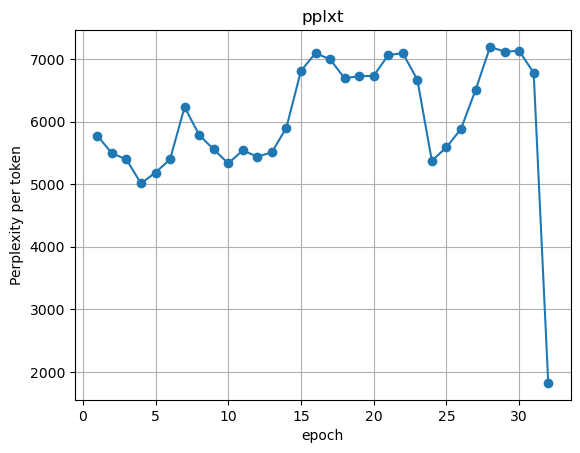


Results:
Total tokens: 62957
Average loss: 3.0630
Perplexity: 21.39


In [ ]:
def calculate_perplexity(model, loader, device):
    model.eval()
    
    total_loss = []
    sum_loss = 0
    total_tokens = 0
    
    print("\nCalculating perplexity...")
    with torch.no_grad():
        for batch in tqdm(loader):
            batch = batch.to(device)
            
            input_ids = batch[:, :-1]
            target_ids = batch[:, 1:]
            
            logits = model(input_ids)
            logits_flat = logits.reshape(-1, logits.size(-1))
            target_flat = target_ids.reshape(-1)
            
            loss = F.cross_entropy(
                logits_flat, 
                target_flat, 
                ignore_index = 0,
                reduction='sum'
            )
            
            num_tokens = (target_ids != 0).sum().item()
            
            total_loss.append(loss)
            sum_loss += loss.item()
            total_tokens += num_tokens
            
    plt.plot(range(1, len(total_loss)+1), total_loss, marker = 'o')
    plt.title('pplxt')
    plt.xlabel('epoch')
    plt.ylabel('Perplexity per token')
    plt.grid(True)
    plt.show()
    
    # average loss and perplexity
    avg_loss = sum_loss / total_tokens
    perplexity = math.exp(avg_loss)
    
    print(f"\nResults:")
    print(f"Total tokens: {total_tokens}")
    print(f"Average loss: {avg_loss:.4f}")
    print(f"Perplexity: {perplexity:.2f}")
    
    return perplexity

ppl = calculate_perplexity(model, val_loader, device)